In [1]:
import cvxpy as cvx
import numpy as np
import networkx as nx
import scipy.linalg as sla
import mosek
import matplotlib.pyplot as plt
%precision %.2f
np.set_printoptions(precision=2)

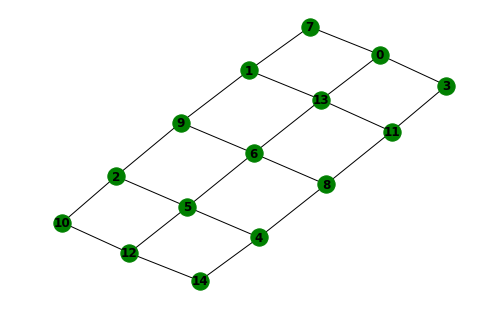

In [2]:
# networks Set up 
# Create Graph Object
rowSize = 3; colSize = 5;

G = nx.grid_graph([rowSize,colSize])
e = G.number_of_edges();
v = G.number_of_nodes();


# --------Source Vector set up ----------------#
sourceNode = 14; 
sinkNode = 7;
sourceVec = np.zeros((v));
sourceVec[sourceNode] = -1;
sourceVec[sinkNode] = 1;

#---------Draw Graph---------#
G = nx.convert_node_labels_to_integers(G)
pos=nx.spring_layout(G);
nx.draw(G, pos=pos, node_color='g', edge_color='k', with_labels=True, font_weight='bold')
edgeList = list(G.edges);

In [3]:
def generateMDP(S,A):
    """
    Generates a random MDP with finite sets X and U such that |X|=S and |U|=A.
    
    Parameters
    ----------
    S : int
        Cardinality of state space.
    A : int
        Cardinality of input space.
        
    Returns
    -------
    P : (S,S,A) array
        Transition probability tensor such that ``P[i,j,k]=prob(x_next=i | x_now=j, u_now=k)``.
    c : (S,A) array
        Cost such that ``c[i,j]=cost(x_now=i,u_now=j)``.
    """
    P, c = np.zeros((S,S,A)), np.random.uniform(size=(S,A))
    for j in range(S):
        for k in range(A):
            P[:,j,k] = np.random.uniform(size=S)
            P[:,j,k] /= np.sum(P[:,j,k])
    return P, c

In [33]:
def generateGridMDP(v,a,G,p = 0.8):
    """
    Generates a grid MDP based on given graph. p is the probability of reaching the target state given an action.
    
    Parameters
    ----------
    v : int
        Cardinality of state space.
    a : int
        Cardinality of input space.
        
    Returns
    -------
    P : (S,S,A) array
        Transition probability tensor such that ``P[i,j,k]=prob(x_next=i | x_now=j, u_now=k)``.
    """
    debug = False;
    # making the transition matrix
    P = np.zeros((v,v,a));
    for node in range(v):#x_now = node
        neighbours = list(G.neighbors(node));
        totalN = len(neighbours);
        # chance of not reaching action
        pNot = (1.-p)/(totalN-1);
        actionIter = 0;
        if debug: 
            print neighbours;
        for neighbour in neighbours: # neighbour = x_next
            P[neighbour,node,actionIter] = p;
            for scattered in neighbours:
                if debug:
                    print scattered;
                if scattered != neighbour:
                    P[scattered,node,actionIter] = pNot;
            actionIter += 1;
        while actionIter < a:         
            P[node, node, actionIter] = p;
            pNot = (1.-p)/(totalN);
            for scattered in neighbours: 
                P[scattered,node,actionIter] = pNot;
            actionIter += 1;
    # making the cost function
    c = np.random.uniform(size=(v,a))
    return P,c;
#     for j in range(S):
#         for k in range(A):
#             P[:,j,k] = np.random.uniform(size=S)
#             P[:,j,k] /= np.sum(P[:,j,k])
#     return P, c

In [31]:
P,C = generateMDP(S = 3, A = 5)
print np.sum(P[:,0,:],axis=0)

[ 1.  1.  1.  1.  1.]


In [34]:
states = 1*v; actions = 5; # left right up down stay
P,c = generateGridMDP(15,5,G);
# print P
print np.sum(P[:,0,:],axis=0)
# print c
# print v

[ 1.  1.  1.  1.  1.]


In [36]:
# Construct the problem.
#----------------MDP Routing Game--------------------
mass = 10.0;
time = 10;
v = 15; states = 15;
R = np.zeros((states, actions,time))
print v
# Construct the time dependent reward
for t in range(time):
    R[:,:,t] = 1.0*c;

# x is 3D array with dimensions p x q x r.
y_ijt = {}
# y_ijt = cvx.Variable(states, actions,time)

for i in range(states):
    for j in range(actions):
        for t in range(time):
            y_ijt[(i,j,t)] = cvx.Variable() 
    
mdpObj = cvx.Minimize(sum([sum([sum([y_ijt[(i,j,t)]*R[i,j,t] for i in range(states) ]) for j in range(actions)]) for t in range(time)]))
mdpConstraints = []

for t in range(time):  
    for i in range(states):
        for j in range(actions):
            mdpConstraints.append(y_ijt[(i,j,t)] >= 0.)
        if t < time-1:
            prevProb = sum([sum([y_ijt[(iLast,j,t)]*P[i,iLast,j] for iLast in range(states) ]) for j in range(actions)]) ;
            newProb = sum([y_ijt[(i,j,t+1)] for j in range(actions)]);
            mdpConstraints.append(newProb == prevProb);
            
        
for i in range(states):
    initState = sum([y_ijt[(i,j,0)] for j in range(actions)]) ;
    if i == 2:
        mdpConstraints.append(initState == 1.)
    else:
        mdpConstraints.append(initState == 0.)

    
mdpPolicy = cvx.Problem(mdpObj,mdpConstraints)

mdpRes = mdpPolicy.solve(verbose=True)

15

ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +4.747e+00  +4.747e+00  +1e+03  9e-01  5e-01  1e+00  2e+00    ---    ---    1  1  - |  -  - 
 1  -3.087e+00  -3.178e+00  +2e+02  3e-01  4e-02  6e-03  3e-01  0.8620  2e-02   0  1  1 |  0  0
 2  +3.318e-01  +3.123e-01  +9e+01  1e-01  2e-02  7e-03  1e-01  0.6176  1e-01   0  0  0 |  0  0
 3  +7.675e-01  +7.615e-01  +4e+01  3e-02  7e-03  5e-03  6e-02  0.7120  3e-01   1  0  0 |  0  0
 4  +8.751e-01  +8.724e-01  +2e+01  1e-02  3e-03  3e-03  3e-02  0.6680  3e-01   0  0  0 |  0  0
 5  +1.015e+00  +1.015e+00  +7e+00  3e-03  9e-04  8e-04  9e-03  0.7093  2e-02   1  0  0 |  0  0
 6  +1.064e+00  +1.064e+00  +2e+00  9e-04  2e-04  2e-04  3e-03  0.8378  2e-01   1  0  0 |  0  0
 7  +1.077e+00  +1.077e+00  +5e-01  2e-04  6e-05  6e-05  7e-04  0.7949  6e-02   1  0  0 |  0  0
 8  +1.080e+00  +1.080e+00  +1e-01  6e-05  

In [ ]:
y_ijt[(0,0,0)].value

In [37]:
def cvxDict2Arr(optDict,s,a,t):
    arr = np.zeros((s,a,t));
    for i in range(s):
        for j in range(a):
            for k in range(t):
                arr[i,j,k] = 1.*optDict[(i,j,k)].value;
                
    return arr;
    

In [38]:
optRes = cvxDict2Arr(y_ijt,states, actions, time);
print np.sum(optRes[:,:,time-1],axis=0)
final = np.sum(optRes[:,:,time-1],axis=1);
print final

[  1.04e-01   7.99e-02   1.85e-01   3.68e-12   6.31e-01]
[ 0.    0.1   0.22  0.01  0.3   0.05  0.02  0.01  0.04  0.13  0.07  0.
  0.01  0.02  0.02]


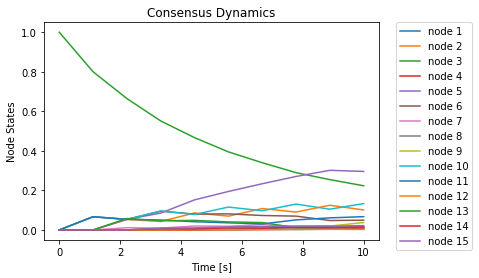

In [39]:

plt.figure()
timeLine = np.linspace(0,time,time);
for i in range(states):
    plt.plot(timeLine,np.sum(optRes[i,:,:], axis=0),label=(r'node %i'%(i+1)));
plt.xlabel('Time [s]')
plt.ylabel('Node States')
plt.title('Consensus Dynamics')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

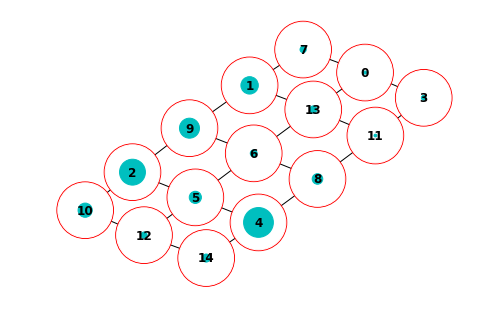

In [48]:

mag = 3000;
nodesize=[final[v]*mag for v in G]
cap = mag* np.ones(len(nodesize));
nx.draw(G, pos=pos, node_color='w',with_labels=True, font_weight='bold')
nx.draw_networkx_nodes(G,pos,node_size=3.2/3*cap,node_color='r',alpha=1)
nx.draw_networkx_nodes(G,pos,node_size=cap,node_color='w',alpha=1)

nx.draw_networkx_nodes(G,pos,node_size=nodesize,node_color='c',alpha=1)
